# Block VQE by Qubit

Here we will split the Hilbert space into two groups, one which will be calculated classically and the other with will be calculated using block-VQE.  Instead of splitting the Hilbert space into spin-up and spin-down as we did before, here I will split the Hilbert space into general sets of qubits.  

The wavefunction is divided into classical and quantum parts
$$
    |\psi> = \sum_c \alpha_c |c>|\psi_{qc}>
$$
where $|c>$ is a basis state in the classical section and $|\psi_q>$ is the wavefunction in the quantum section.  The weights $\alpha_c$ have to be solved classically while the wavefunctions $|\psi_{qc}>$ will be updated using VQE.  

Let's do a simple X-Y-Z model with closed boundary conditions to test the algorithm.  
$$ 
    H =  \sum_{i} \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right) 
$$

Let us take the first $N_c$ qubits to be in the classical sector.  Then we can take energy expectation values as,
\begin{equation}
\begin{split}
&<\psi|H|\psi> = \sum_{cc'}\alpha_c\alpha_c'<\psi_{qc'}|<c'| H |c> |\psi_{qc}>=
\\
& \sum_{cc'}\alpha_c\alpha_c' \left( \sum_{i=0}^{N_c-2}  <c'|\left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right)|c><\psi_{qc'}|\psi_{qc}>  + \delta_{cc'}\sum_{i=N_c+1}^{N} <\psi_{qc'}| \ \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right) |\psi_{qc}> \right) 
\\
&+ \sum_{cc'}\alpha_c\alpha_c'  \left( <c'|X_{N_c-1}|c><\psi_{qc'}|X_{N_c}|\psi_{qc}> + <c'|Y_{N_c-1}|c> <\psi_{qc'}|Y_{N_c}|\psi_{qc}> + <c'|Z_{N_c-1}|c><\psi_{qc'}|Z_{N_c}|\psi_{qc}> \right) 
\end{split}
\end{equation}

Anything in the classical brakets are calculated classically while anything in the quantum brackets are calculated using quantum hardware.  Notice that some of the quantum brakets are wieghted by classical brackets.  This is not a problem.  

## Classical part

### Define Pauli Matrices

Let us define the Pauli matrices so we can do the classical calculations.

In [1]:
import qiskit.quantum_info as qi

def X(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'X'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Y(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Y'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Z(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Z'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

### Generate the states

We need a function which gives you the classical basss for a given number of qubits.

In [2]:
# A function to print the state given the numerical represenations
def bi(num,N):
    bi = bin(num)
    out = []
    Sdiff = N - len(bi) + 2
    for i in range(0,Sdiff):
        out.append(0)
    for i in range(2,len(bi)):
        out.append(int(bi[i]))
    return out

# A function which retruns the numerical representation of states given N
def states(N):
    out = [i for i in range(0,2**N)]
    return out

# A function to print the basis vectors given the number of qubits N
def vecs(N):
    out = []
    for i in range(2**N):
        v = [0 for i in range(2**N)]
        v[i] = 1
        out.append(v)
    return out

In [3]:
import numpy as np

def Mdot(Ol):
    out = Ol[0]
    for i in range(1,len(Ol)):
        out = np.dot(Ol[i],out)
    return out

def bkt(y1,O,y2):
    return Mdot([np.conjugate(y1),O,y2])


### Full Hamiltoniain

Let us write the un-partitioned Hamiltonain so we can compare to it later.

In [4]:
def H(x,y,z,N):
    h = 0*X(0,N)
    for i in range(0,N-1):
        h += x*Mdot([X(i,N),X(i+1,N)]) + y*Mdot([Y(i,N),Y(i+1,N)]) + z*Mdot([Z(i,N),Z(i+1,N)])
    return h
        
    
import pandas as pd
#pd.DataFrame(H(1,2,3,4))

### Calculating the classical brakets

We can calculate all of the classical brakets before we start VQE.  Once we have the value of each braket we simply store it as a weight for the various quantum brakets.  There are five types of classical brakets we need to calculate.

\begin{equation}
\begin{split}
& T_{c,c'} =  <c'|\sum_{i=0}^{N_c-2}\left(x X_{i\sigma}X_{i+1\sigma} + y Y_{i\sigma} Y_{i+1\sigma} + z Z_{i\sigma} Z_{i+1\sigma}\right)|c> 
\\
& B1^x_{c,c'} =  x<c'|X_{N_c-1}|c>
\\
&B1^y_{c,c'} = y<c'|Y_{N_c-1}|c> 
\\
&B1^z_{c,c'} = z<c'|Z_{N_c-1}|c> 
\end{split}
\end{equation}

In [5]:
def T(x,y,z,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    for i in range(0,Nc-1):
        O = x*Mdot([X(i,Nc),X(i+1,Nc)]) + y*Mdot([Y(i,Nc),Y(i+1,Nc)]) + z*Mdot([Z(i,Nc),Z(i+1,Nc)])
        out += bkt(v[cc],O,v[c])
    return out

def Bx(x,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = X(Nc-1,Nc)
    out += bkt(v[cc],x*O,v[c])
    return out

def By(y,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = Y(Nc-1,Nc)
    out += bkt(v[cc],y*O,v[c])
    return out

def Bz(z,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = Z(Nc-1,Nc)
    out += bkt(v[cc],z*O,v[c])
    return out



We Can use these to rewrite the Hamiltoniain.  I will shift the indicies so $ N_c \rightarrow 0 $.

\begin{equation}
\begin{split}
H_{c,c'}=& T_{c,c'} + \delta_{cc'}\sum_{i=0}^{N_q} \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1}  + z Z_{i} Z_{i+1}\right) 
\\
&+ \left(B^{1x}_{c,c'}X_{0} + B^{1y}_{c,c'} Y_{0} + B^{1z}_{c,c'} Z_{0} \right)
\end{split}
\end{equation}

In [6]:
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi


def H_quantum(x,y,z,c,cc,Nc,Nq):
    tcc = T(x,y,z,c,cc,Nc)
    Iq = np.identity(2**Nq)
    h = tcc*Iq
    h += Bx(x,c,cc,Nc)*X(0,Nq)
    h += By(y,c,cc,Nc)*Y(0,Nq)
    h += Bz(z,c,cc,Nc)*Z(0,Nq)
    if c == cc:
        for i in range(0,Nq-1):
            h += x*Mdot([X(i,Nq),X(i+1,Nq)]) + y*Mdot([Y(i,Nq),Y(i+1,Nq)]) + z*Mdot([Z(i,Nq),Z(i+1,Nq)])
    return h
    
    
#H_quantum(1,1,1,3,2,2,2)

In [7]:
def H_quantum(x,y,z,c,cc,Nc,Nq):
    tcc = T(x,y,z,c,cc,Nc)
    Iq = np.identity(2**Nq)
    h = [MatrixOp(tcc*Iq).to_pauli_op()]
    h.append(MatrixOp(Bx(x,c,cc,Nc)*X(0,Nq)).to_pauli_op())
    h.append(MatrixOp(By(y,c,cc,Nc)*Y(0,Nq)).to_pauli_op())
    h.append(MatrixOp(Bz(z,c,cc,Nc)*Z(0,Nq)).to_pauli_op())
    if c == cc:
        for i in range(0,Nq-1):
            h.append(MatrixOp(x*Mdot([X(i,Nq),X(i+1,Nq)])).to_pauli_op())
            h.append(MatrixOp(y*Mdot([Y(i,Nq),Y(i+1,Nq)])).to_pauli_op())
            h.append(MatrixOp(z*Mdot([Z(i,Nq),Z(i+1,Nq)])).to_pauli_op())
    return h

In [8]:
from qiskit.opflow import SummedOp, PauliOp

def Blocks(x,y,z,Nc,Nq):
    bks = {}
    Mc = len(states(Nc))
    for c in range(0,Mc):
        for cc in range(0,Mc):
            Op = H_quantum(x,y,z,c,cc,Nc,Nq)
            bks[str(c) + ',' + str(cc)] =  Op
    return bks
        
    

In [9]:
Blocks(1,2,3,2,2)['0,0']

[PauliOp(Pauli('II'), coeff=3.0),
 PauliOp(Pauli('II'), coeff=0.0),
 PauliOp(Pauli('II'), coeff=0.0),
 PauliOp(Pauli('ZI'), coeff=3.0),
 PauliOp(Pauli('XX'), coeff=1.0),
 PauliOp(Pauli('YY'), coeff=2.0),
 PauliOp(Pauli('ZZ'), coeff=3.0)]

Let us check that we can rebuild the Hamiltoniain.

In [10]:
Nc = 2
Nq = 3
x = 1
y = 2
z = 3
blocks = Blocks(x,y,z,Nc,Nq)

keys = list(blocks.keys())

bL = len(states(Nc))
size = 2**Nq
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            hl = blocks[key]
            block = np.sum(hl).to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]
                

<ipython-input-10-ef49c2b99a7a>:24: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-10-ef49c2b99a7a>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [11]:
np.amax(np.abs(H_complete - np.real(H(x,y,z,Nc+Nq))))

0.0

## Anzats Circuit

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [12]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute

Q = Nq

### Diagonal Blocks

In [13]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

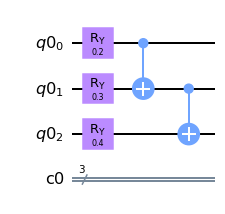

In [14]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4])

tst.draw(output = 'mpl')

In [15]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir

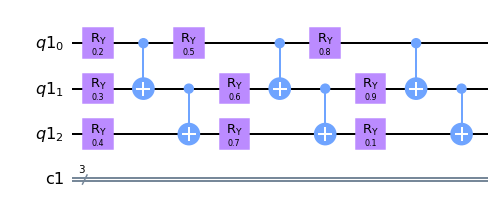

In [16]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

### Off Diagonal Blocks

In [17]:
def Ui_off(cir_i,phi_a, phi_b):  
    
    for q in range(0,Q):
        cir_i.ry(phi_a[q],q)
        cir_i.cx(Q,q)
        cir_i.ry(-(phi_b[q]-phi_a[q])/2,q)
        cir_i.cx(Q,q)
        cir_i.ry((phi_b[q]-phi_a[q])/2,q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

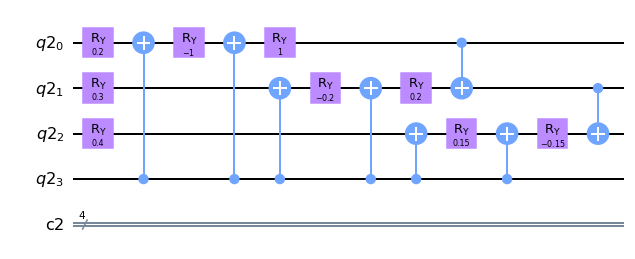

In [18]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
tst = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

tst.draw(output = 'mpl')

In [19]:
#An example block a circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_a = Ui(cir_i,[0.2,0.3,0.4])

#An example block b circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_b = Ui(cir_i,[2.2,0.7,0.1])

#The combination of the two blocks
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
cir_i.h(Q)
tst_off = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

print('A:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_a).data)
print('B:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_b).data)
print('AB:')
print(qi.Statevector.from_instruction(tst_off).data)

A:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j]
B:
[0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]
AB:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j
 0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]


In [20]:
def U_off(cir,phi_a,phi_b):
    T = len(phi_b)
    cir.h(Q)
    for t in range(T):
        cir = Ui_off(cir,phi_a[t],phi_b[t])
    return cir

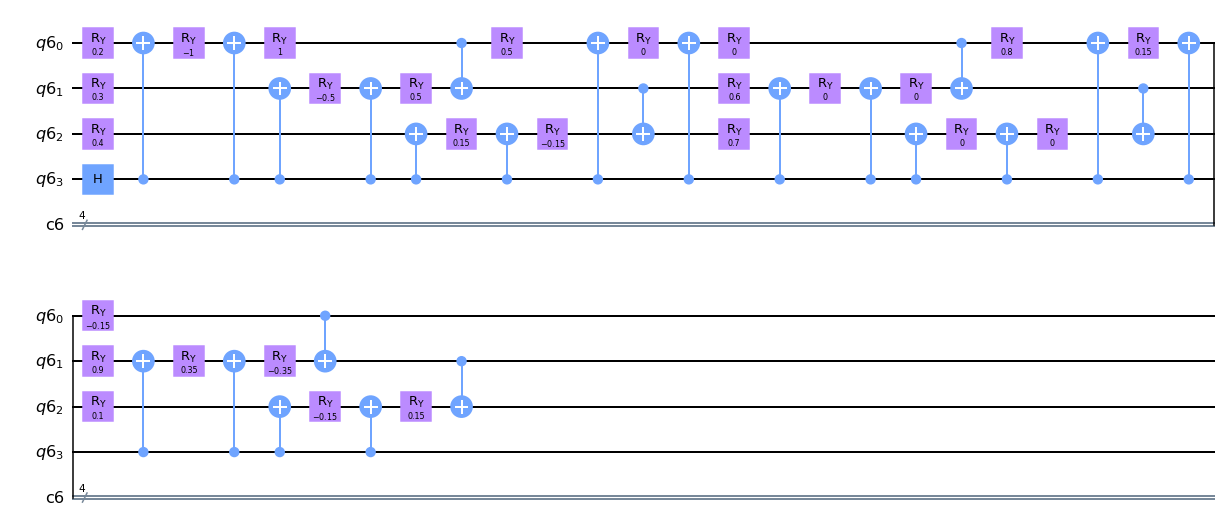

In [21]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
tst = U_off(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]],[[2.2,1.3,0.1],[0.5,0.6,0.7],[0.5,0.2,0.4]])

tst.draw(output = 'mpl')

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

each $H_{ab}$ can be brocken down into its Puali components so that $H_{ab} = \sum_p c_p P_{ab,p}$.  Then we have

$$ E = \sum_{ab}\sum_p c_p <000\ldots|U^{\dagger}(\{\phi^a\})  P_{ab,p}U(\{\phi^b\})|000\ldots>$$.

We cannot measure $<\psi^a|P_{ab,p}|\psi^b>$ directly.  Instead we measure $|<\psi^a|P_{ab,p}|\psi^b>|^2$ which tells us nothing about the sign.  

To fix the issue we need to find a way to use the counts to recreate the desired measurement.  This can be done by looking at the counts in each occupation state. 

First we need to go through the circuit and add a $R_y(-\pi/2)$ gate on each qubit where $P_{ab,p}$ applies an X and an $R_x(\pi/2)$ gate to each qubit where $P_{ab,p}$ applies an Y.  This rotates all of the Pauli terms to Z.   Then we can take the count for each occupation state mulitply that count by $(-1)^n$ where n is the number of up qubits with a Puali term in $P_{ab,p}$. 

for example:

\begin{equation}
\begin{split}
<\psi|XZ|\psi> &= <(R_y(\pi/2)\otimes I)\psi|R^{\dagger}_y(\pi/2)XR_y(\pi/2)\otimes Z|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = <(R_y(\pi/2)\otimes I)\psi|ZZ|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = |<00|R^{\dagger}_y(\pi/2)\psi>|^2 + (-1)^1|<10|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^1|<01|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^2|<11|R^{\dagger}_y(\pi/2) \psi>|^2
\end{split}
\end{equation}

This unfortunetly does not work for $|\psi^a> \neq |\psi_b>$



In [56]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def measure_pauli(p_label,psi0,method = 'simple'):
    
    #Simple method of calculation####
    if method == 'simple':
        wave0 = qi.Statevector.from_instruction(psi0)
        Op = qi.Operator.from_label(p_label)
        return np.dot(np.conjugate(wave0),np.dot(Op,wave0))
    #################################
        
    #apply rotations#################
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    ################################
    
    #Using matrix multiplication####
    if method == 'matrix':
        # add results
        wave = qi.Statevector.from_instruction(psi)
        r = wave.probabilities_dict()
        z_measure = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
        return z_measure
    #################################
    
    #Using the qasm simulator########
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        psi.measure(psi.qubits,psi.clbits)
        r = execute(psi, backend = sim).result().get_counts()
        z_measure = 0
        total = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
            total += r[key]
        return z_measure/total
    ###################################
    
    raise NameError(method + ' is not a recognized method')
    return method + ' is not a recognized method'
  

#Run a test
import copy
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[[1.2,2.3,3.4]])
p_label = blocks['0,0'][7].primitive.to_label()
        
    
print( measure_pauli(p_label,psi0,method = 'simple') )
print( measure_pauli(p_label,psi0,method = 'matrix') )
print( measure_pauli(p_label,psi0,method = 'simulator') )
#print( measure_pauli(p_label,psi0,method = 'Moon_Cheese') )

(-0.2381742951601455+0j)
-0.2381742951601454
-0.232421875


In order to calculate things like 
$$<\psi^a|ZZ|\psi^b>$$ 
we will need to add another qubit and build the combined statevector 
$$ |\psi^{ab}> = |0>|\psi^a> + |1>|\psi_b> $$
then we can calculate
$$ <\psi^{ab}|X\otimes ZZ|\psi^{ab}> = <\psi^{ab}|\left(|1>ZZ|\psi^a> + |0>ZZ|\psi_b> \right) = <\psi^{a}|ZZ|\psi^{b}> + <\psi^{b}|ZZ|\psi^{a}>  $$ 
$$ <\psi^{ab}|Y\otimes ZZ|\psi^{ab}> = <\psi^{ab}|\left(|1>ZZ|\psi^a> + |0>ZZ|\psi_b> \right) = i<\psi^{a}|ZZ|\psi^{b}> - i<\psi^{b}|ZZ|\psi^{a}>  $$ 

$$ <\psi^{ab}|X\otimes ZZ|\psi^{ab}> +  i <\psi^{ab}|Y\otimes ZZ|\psi^{ab}> = <\psi^{a}|ZZ|\psi^{b}> $$

In order to form the combined statevector we need to create a circuit which performs 
$$ U^{ab} = I\otimes U^a + X \otimes U^b$$
This as done in the Ansatz section.   Here we will use that result to calculate E.

In [63]:
import random
random.seed(0)

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#Create an arbitrary collection of rotation angles
T = 1
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            rand = random.random()
            phi_t.append(rand)
        phi_b.append(phi_t)
    phi.append(phi_b)

#Find the energy contribution from diagonal blocks
def E_on_block(phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi0 = U(cir,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli( p_label,psi,method = method)
        E += w*E_p
    return E
        
        
block = blocks['0,0']
phi_b = phi[0]

M_b = np.sum(block).to_matrix()
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,phi_b)
wave = qi.Statevector.from_instruction(psi0).data
print('check:',np.dot(np.conjugate(wave),np.dot(M_b,wave)))

print('simple:',E_on_block(phi_b,block,method = 'simple'))
print('matrix:',E_on_block(phi_b,block,method = 'matrix'))
print('simulator:',E_on_block(phi_b,block,method = 'simulator'))
#print('mooncheese:',E_on_block(phi_b,block,method = 'mooncheese'))

check: (8.53249562426362+0j)
simple: (8.53249562426362+0j)
matrix: 8.532495624263618
simulator: 8.3046875


In [66]:
# Find the energy contribution from off diagonal blocks
def E_off_block(phi_a,phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi0 = U_off(cir,phi_a,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_px = measure_pauli('X' + p_label,psi,method = method)
        E_py = measure_pauli('Y' + p_label,psi,method = method)
        E += w*(E_px + 1j*E_py)/2
    return E

block = blocks['0,1']
phi_a = phi[0]
phi_b = phi[1]
M_b = np.sum(block).to_matrix()
#A
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_a = U(cir,phi_a)
wave_a = qi.Statevector.from_instruction(psi_a).data
#B
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_b = U(cir,phi_b)
wave_b = qi.Statevector.from_instruction(psi_b).data
print('check:',1/2*np.dot(np.conjugate(wave_a),np.dot(M_b,wave_b)))

print('simple:',E_off_block(phi_a,phi_b,block,method = 'simple'))
print('matrix:',E_off_block(phi_a,phi_b,block,method = 'matrix'))
print('simulator:',E_off_block(phi_a,phi_b,block,method = 'simulator'))
#print('mooncheese:',E_off_block(phi_a,phi_b,block,method = 'mooncheese'))

check: (0.19593627257966623+0j)
simple: (0.19593627257966625+0j)
matrix: (0.19593627257966623+5.204170427930421e-17j)
simulator: (0.1748046875+0.0185546875j)


In [69]:
# The total energy 
def find_E(alpha,phi,blocks,method = 'simple'):
    E = 0
    for key in list(blocks.keys()):
        if key[0] == key[2]:
            E += alpha[int(key[0])]*alpha[int(key[2])]*E_on_block(phi[int(key[0])],blocks[key],method = method)
        else:
            E += 2*alpha[int(key[0])]*alpha[int(key[2])]*E_off_block(phi[int(key[0])],phi[int(key[2])],blocks[key],method = method)
    return E
            
find_E(alpha,phi,blocks)

(5.699396138634345+0j)

In [70]:
#Check against H_complete               
wave_full = []
for b in range(bL):
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi_b = U(cir,phi[b])
    wave_b = alpha[b]*qi.Statevector.from_instruction(psi_b).data
    wave_full.append(wave_b)
wave_full = np.array(wave_full).flatten()

np.dot(np.conjugate(wave_full),np.dot(H_complete,wave_full))


(5.699396138634346+0j)

First we need to inialize our set of parameters.  To do this we need to decide on the number of times we will apply Ui.  As a first attempt let's just have a depth of 1 (i.e. $U = Ui$).  

In this case, we need a parameter for each qubit for each section.

In [71]:
alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#number of blocks
T = 2
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)
    
find_E(alpha,phi,blocks)

(7+0j)

# Optimizaition

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [41]:
import copy

In [74]:
#beta = 0.602
beta = 0.201
A = 10
a = 0.05
gamma = 0.101
c = 0.4

beta_a = beta
A_a = A
a_a = a
gamma_a = gamma
c_a = c

def SPSA(k_max,method = 'simple',hold = False, seed = 'False'):
    #Initalization
    if seed == 'True': np.random.seed(0)
    k = 0
    phi_k = np.array(phi)
    alpha_k = np.array(alpha)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p=0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
            
        #Find E    
        E_A = find_E(alpha_k_A, phi_k_A, blocks, method = method)
        E_B = find_E(alpha_k_B, phi_k_B, blocks, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Calculate new E
        E_f = np.real(find_E(alpha_k,phi_k,blocks, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        #print('k = ', k ,' E_f = ', E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [76]:
out = SPSA(2000,method = 'simple',hold = True, seed = 'True')

k= 0 c_k= 0.4 a_k= 0.030878064824598282 g= 4.455732931752723 E_A= (6.394769974311853+0j) E_B= (2.830183628909674+0j) E_f= 5.258741406612572
k= 1 c_k= 0.372954594574733 a_k= 0.030342724499598534 g= -6.1643818225734215 E_A= (3.4707413889781233+0j) E_B= (8.068810435861572+0j) E_f= 4.477584957491599
k= 2 c_k= 0.3579898757427053 a_k= 0.029858459038837503 g= -3.831874134187575 E_A= (2.9701641465724364+0j) E_B= (5.713708436891429+0j) E_f= 4.180102714107959
k= 3 c_k= 0.34773782403600867 a_k= 0.029416992458941946 g= 2.2572047002580855 E_A= (3.496420674330254+0j) E_B= (1.9265897725870582+0j) E_f= 3.8590587539580428
k= 4 c_k= 0.33998833831625347 a_k= 0.02901186589249766 g= 4.3223789035185325 E_A= (5.353009077193743+0j) E_B= (2.4138922352327516+0j) E_f= 3.604119965369118
k= 5 c_k= 0.3337849224236992 a_k= 0.028637947449493925 g= 0.5502544151683465 E_A= (3.418151306475763+0j) E_B= (3.050818051915234+0j) E_f= 3.5798434299573247
k= 6 c_k= 0.32862839767254015 a_k= 0.028291095918097278 g= 2.645762464989

k= 52 c_k= 0.267860162826851 a_k= 0.021742153317333094 g= 1.4465370446135284 E_A= (-5.908380348471427+0j) E_B= (-6.68331964508193+0j) E_f= -10.38757993011061
k= 53 c_k= 0.26735494522142605 a_k= 0.021673439087867164 g= -0.32824853581819624 E_A= (-7.626302010519752+0j) E_B= (-7.450784271894378+0j) E_f= -10.436780678439918
k= 54 c_k= 0.2668599250350944 a_k= 0.02160600238280336 g= 3.6589026002815213 E_A= (-6.705555505065247+0j) E_B= (-8.658384452308924+0j) E_f= -10.417266222193925
k= 55 c_k= 0.26637471655715955 a_k= 0.021539800337028216 g= -10.269947911092423 E_A= (-10.166279830767683+0j) E_B= (-4.694970903019609+0j) E_f= -10.535188844970083
k= 56 c_k= 0.2658989552298248 a_k= 0.02147479214577462 g= -8.313996802463324 E_A= (-9.588259410639981+0j) E_B= (-5.166893283521778+0j) E_f= -10.455335930742637
k= 57 c_k= 0.26543229614067565 a_k= 0.021410938936572577 g= -6.494924808976153 E_A= (-9.371844426378786+0j) E_B= (-5.923918815763627+0j) E_f= -10.245046111068856
k= 58 c_k= 0.26497441264651617 a

k= 104 c_k= 0.24998840873867942 a_k= 0.019265032163888564 g= 4.8815504739381534 E_A= (-6.203107786260839+0j) E_B= (-8.64376985657553+0j) E_f= -9.575884210006944
k= 105 c_k= 0.24974919607452548 a_k= 0.01923153495014902 g= 1.5631896869824282 E_A= (-7.629822680467748+0j) E_B= (-8.410633415739449+0j) E_f= -9.741645976418967
k= 106 c_k= 0.2495124552599996 a_k= 0.01919838276571559 g= 9.773047438842243 E_A= (-5.197043189151574+0j) E_B= (-10.074037312827532+0j) E_f= -10.374582543225792
k= 107 c_k= 0.24927813800651724 a_k= 0.019165569152951475 g= -12.285233214438312 E_A= (-10.403643504102275+0j) E_B= (-4.278763382760269+0j) E_f= -10.524691093995067
k= 108 c_k= 0.24904619740500722 a_k= 0.01913308782851349 g= -2.657215740130855 E_A= (-9.288336387656054+0j) E_B= (-7.964797436127411+0j) E_f= -10.797575264580583
k= 109 c_k= 0.24881658787426822 a_k= 0.019100932677229843 g= -7.121178471664982 E_A= (-9.926835663731083+0j) E_B= (-6.3831010058043285+0j) E_f= -10.771148637649492
k= 110 c_k= 0.248589265111

k= 155 c_k= 0.2401897150315199 a_k= 0.017894858911911237 g= 5.314967065651265 E_A= (-8.959038400668351+0j) E_B= (-11.512239250469733+0j) E_f= -11.556804292566346
k= 156 c_k= 0.24003475389827156 a_k= 0.017873269078684573 g= 5.0760940575084605 E_A= (-8.340589457737345+0j) E_B= (-10.777467433454389+0j) E_f= -11.546292101644966
k= 157 c_k= 0.23988087567680955 a_k= 0.017851833955768864 g= -0.4399647267819074 E_A= (-9.967849703291241+0j) E_B= (-9.756771455436537+0j) E_f= -11.532617948569738
k= 158 c_k= 0.239728066017013 a_k= 0.01783055152347874 g= 2.578618414444434 E_A= (-9.001768163921508+0j) E_B= (-10.238102574902749+0j) E_f= -11.464464966955697
k= 159 c_k= 0.23957631084767136 a_k= 0.01780941980024826 g= 5.486015377246266 E_A= (-7.829536487191882+0j) E_B= (-10.458175137860396+0j) E_f= -11.49502490669929
k= 160 c_k= 0.2394255963693599 a_k= 0.01778843684169224 g= 1.0114035766017193 E_A= (-9.197660253064303+0j) E_B= (-9.681972062060243+0j) E_f= -11.55152444425493
k= 161 c_k= 0.239275909047540

k= 206 c_k= 0.23342479519724088 a_k= 0.016956710197876357 g= 0.5810884554732824 E_A= (-9.755660318777668+0j) E_B= (-10.026941226198332+0j) E_f= -12.263671033620193
k= 207 c_k= 0.23331120380879006 a_k= 0.016941047069765323 g= -4.727832259658268 E_A= (-10.815925482237036+0j) E_B= (-8.609813010423231+0j) E_f= -12.130776995044556
k= 208 c_k= 0.2331982121051757 a_k= 0.016925469995779104 g= -2.8251619447980887 E_A= (-10.365703451479911+0j) E_B= (-9.04805802261092+0j) E_f= -11.964615633231219
k= 209 c_k= 0.23308581407379206 a_k= 0.016909978113415238 g= 5.642273574893757 E_A= (-8.881774475237163+0j) E_B= (-11.512042334099476+0j) E_f= -11.992419266074473
k= 210 c_k= 0.232974003790588 a_k= 0.01689457057268661 g= -2.3883074005168403 E_A= (-10.536314038475917+0j) E_B= (-9.423486963713717+0j) E_f= -12.038578193389887
k= 211 c_k= 0.23286277541835038 a_k= 0.016879246535884136 g= 2.6819030946455578 E_A= (-9.709662476961489+0j) E_B= (-10.958693273005943+0j) E_f= -11.965591101246464
k= 212 c_k= 0.232752

k= 257 c_k= 0.22828974396591784 a_k= 0.016252303008687845 g= -3.174534441392059 E_A= (-11.048869135981787+0j) E_B= (-9.599441826309025+0j) E_f= -12.138077810043596
k= 258 c_k= 0.22820056489801344 a_k= 0.01624014101894129 g= 4.517216853234716 E_A= (-8.782491185428572+0j) E_B= (-10.84415406077855+0j) E_f= -12.010176757792216
k= 259 c_k= 0.22811176412405826 a_k= 0.01622803320780049 g= -6.001067392691844 E_A= (-11.618134724355755+0j) E_B= (-8.880306585207157+0j) E_f= -12.208652015030957
k= 260 c_k= 0.22802333859359442 a_k= 0.016215979134588294 g= 3.0739123838623614 E_A= (-10.250132584390768+0j) E_B= (-11.651980113015748+0j) E_f= -12.389286534616273
k= 261 c_k= 0.22793528529233112 a_k= 0.016203978363821238 g= -1.3378182684990523 E_A= (-10.874030026547999+0j) E_B= (-10.264158049148751+0j) E_f= -12.479302385862429
k= 262 c_k= 0.22784760124157974 a_k= 0.016192030465129542 g= -3.8216620064046998 E_A= (-11.266642619456533+0j) E_B= (-9.525129577625746+0j) E_f= -12.43274509301869
k= 263 c_k= 0.227

k= 308 c_k= 0.22416829307647623 a_k= 0.015693075965474278 g= 5.5215850616314865 E_A= (-9.863757400280814+0j) E_B= (-12.339285996965815+0j) E_f= -12.926877792583923
k= 309 c_k= 0.22409515148215373 a_k= 0.015683206422906985 g= 4.280137412218238 E_A= (-9.270896552396135+0j) E_B= (-11.189212635907094+0j) E_f= -12.718872519285572
k= 310 c_k= 0.2240222691984007 a_k= 0.01567337385263873 g= 2.3632754530122595 E_A= (-10.754110876014288+0j) E_B= (-11.812963535463657+0j) E_f= -12.755805243539692
k= 311 c_k= 0.2239496444765029 a_k= 0.015663578001634454 g= -1.0942526567795146 E_A= (-10.934996857939035+0j) E_B= (-10.444881871032553+0j) E_f= -12.71340891699667
k= 312 c_k= 0.22387727558509607 a_k= 0.015653818619369854 g= 1.9416843874459921 E_A= (-10.093012211678284+0j) E_B= (-10.962410233093333+0j) E_f= -12.767458622313677
k= 313 c_k= 0.2238051608099392 a_k= 0.01564409545779878 g= -6.567624712538025 E_A= (-12.396989443285696+0j) E_B= (-9.457252833427889+0j) E_f= -12.891785561910371
k= 314 c_k= 0.22373

k= 359 c_k= 0.22073613743405993 a_k= 0.015232158767708136 g= 0.9760183335104363 E_A= (-11.740722543801756+0j) E_B= (-12.1716075778096+0j) E_f= -13.874473855587473
k= 360 c_k= 0.22067430319994108 a_k= 0.015223897403529201 g= -0.5512230527059314 E_A= (-11.754941466294714+0j) E_B= (-11.511659940167462+0j) E_f= -13.873968561594742
k= 361 c_k= 0.2206126572647566 a_k= 0.015215662739822751 g= 11.449407281908705 E_A= (-8.59343562395923+0j) E_B= (-13.645203953095898+0j) E_f= -13.959154855967595
k= 362 c_k= 0.2205511985373019 a_k= 0.015207454618865354 g= 5.4101575787625045 E_A= (-9.682948898516694+0j) E_B= (-12.069382375060169+0j) E_f= -13.795524816917926
k= 363 c_k= 0.22048992593568012 a_k= 0.015199272884284947 g= -4.036529552018889 E_A= (-12.035080842802266+0j) E_B= (-10.255052638878608+0j) E_f= -13.890399420005393
k= 364 c_k= 0.22042883838719754 a_k= 0.015191117381045689 g= -8.281314024694728 E_A= (-13.122451093167935+0j) E_B= (-9.471570231601802+0j) E_f= -13.855124464128291
k= 365 c_k= 0.220

k= 410 c_k= 0.2178020521092889 a_k= 0.014841893231637726 g= 4.07702859265371 E_A= (-11.05445925914813+0j) E_B= (-12.830429647124578+0j) E_f= -14.097968772355284
k= 411 c_k= 0.21774860054507708 a_k= 0.01483481728679895 g= 5.290670580850531 E_A= (-10.489300240835682+0j) E_B= (-12.793372470686108+0j) E_f= -14.306378780419964
k= 412 c_k= 0.21769529163061768 a_k= 0.014827761451299215 g= -1.292967738076711 E_A= (-11.987370332704812+0j) E_B= (-11.424424355085632+0j) E_f= -14.308686689423386
k= 413 c_k= 0.21764212464119265 a_k= 0.014820725620651613 g= 0.6257264695573872 E_A= (-11.33795812066478+0j) E_B= (-11.610326997222185+0j) E_f= -14.329708786952079
k= 414 c_k= 0.217589098857505 a_k= 0.014813709691156947 g= 1.8830664426554578 E_A= (-11.40400460728362+0j) E_B= (-12.223474067976037+0j) E_f= -14.314781157846985
k= 415 c_k= 0.2175362135656255 a_k= 0.014806713559895953 g= -0.8183114922746034 E_A= (-12.103350299285767+0j) E_B= (-11.747325532192459+0j) E_f= -14.321568844172978
k= 416 c_k= 0.217483

k= 461 c_k= 0.2152440483769229 a_k= 0.014504663658363552 g= 4.738293478470601 E_A= (-10.344086173865541+0j) E_B= (-12.38386511527351+0j) E_f= -13.671375370577287
k= 462 c_k= 0.21519704884440038 a_k= 0.014498494730401415 g= 3.9749071826325038 E_A= (-10.434003443157046+0j) E_B= (-12.144780033422895+0j) E_f= -13.942806647319394
k= 463 c_k= 0.21515016094269962 a_k= 0.01449234144618824 g= 2.1142630157107565 E_A= (-10.099508151976007+0j) E_B= (-11.00927620818674+0j) E_f= -13.914511656649138
k= 464 c_k= 0.21510338416695282 a_k= 0.014486203733174744 g= 4.87393806756086 E_A= (-10.450623201739141+0j) E_B= (-12.5474243468441+0j) E_f= -13.726503347475127
k= 465 c_k= 0.215056718015655 a_k= 0.014480081519299942 g= -1.890289252090158 E_A= (-12.223538177980146+0j) E_B= (-11.410499372670593+0j) E_f= -13.658119886550665
k= 466 c_k= 0.21501016199063455 a_k= 0.014473974732986823 g= 5.730760621537582 E_A= (-9.64200475327844+0j) E_B= (-12.10634829241113+0j) E_f= -13.78643377296897
k= 467 c_k= 0.214963715597

k= 512 c_k= 0.21297966395158172 a_k= 0.014208595965656191 g= -1.568430653848496 E_A= (-11.30640850024662+0j) E_B= (-10.638320833070596+0j) E_f= -13.60121711409691
k= 513 c_k= 0.21293777721836393 a_k= 0.014203141561731296 g= -4.771411050774023 E_A= (-13.042304144236276+0j) E_B= (-11.010276817542358+0j) E_f= -13.610250267275777
k= 514 c_k= 0.21289598011156907 a_k= 0.014197699644913457 g= -2.5804328552247666 E_A= (-11.819106168525725+0j) E_B= (-10.720378604875382+0j) E_f= -13.70018316685815
k= 515 c_k= 0.2128542722659462 a_k= 0.014192270162911738 g= 1.257918959015255 E_A= (-11.794369708961515+0j) E_B= (-12.329876558142972+0j) E_f= -13.778913670364304
k= 516 c_k= 0.21281265331843718 a_k= 0.014186853063753052 g= 3.746481656415119 E_A= (-11.1160773922563+0j) E_B= (-12.71067479607741+0j) E_f= -13.663131302197613
k= 517 c_k= 0.21277112290815914 a_k= 0.014181448295779648 g= -2.2523445704216725 E_A= (-11.971254612841026+0j) E_B= (-11.012786845991597+0j) E_f= -13.582018175926986
k= 518 c_k= 0.212

k= 563 c_k= 0.21095061790221384 a_k= 0.013945327372318217 g= 6.197913767900823 E_A= (-9.971088544078864+0j) E_B= (-12.585996022165498+0j) E_f= -13.94814408331106
k= 564 c_k= 0.21091287811113657 a_k= 0.013940449180459964 g= -4.24658559511853 E_A= (-12.555849481316933+0j) E_B= (-10.764530301293448+0j) E_f= -13.832692170753596
k= 565 c_k= 0.21087521179100568 a_k= 0.013935581167034524 g= 3.173202011415153 E_A= (-10.980760964006713+0j) E_B= (-12.319060256432344+0j) E_f= -13.894468566675718
k= 566 c_k= 0.21083761866936074 a_k= 0.013930723293188747 g= -5.823330734893943 E_A= (-13.387605078769907+0j) E_B= (-10.932050709031632+0j) E_f= -13.963053116942481
k= 567 c_k= 0.21080009847523 a_k= 0.013925875520284806 g= -1.1639781305208656 E_A= (-12.333389401820295+0j) E_B= (-11.84265599274667+0j) E_f= -13.968509548350553
k= 568 c_k= 0.2107626509391198 a_k= 0.013921037809898625 g= -4.2432134207786305 E_A= (-12.845360411174973+0j) E_B= (-11.056738593047463+0j) E_f= -14.109692830988875
k= 569 c_k= 0.2107

k= 614 c_k= 0.20911423844352794 a_k= 0.013708758345051218 g= -2.8449277422284904 E_A= (-11.830432096427641+0j) E_B= (-10.640602299941689+0j) E_f= -13.473524954785933
k= 615 c_k= 0.20907992681080098 a_k= 0.013704353839315616 g= -1.036946152062159 E_A= (-11.375250084500257+0j) E_B= (-10.941640833340461+0j) E_f= -13.46876695503379
k= 616 c_k= 0.2090456764498162 a_k= 0.013699957775662911 g= 4.626303349859158 E_A= (-9.792071636993116+0j) E_B= (-11.726289063459832+0j) E_f= -13.266230998117246
k= 617 c_k= 0.2090114871521178 a_k= 0.013695570124486635 g= 1.6755168801794083 E_A= (-10.47186599759337+0j) E_B= (-11.17227054734292+0j) E_f= -13.28827628000996
k= 618 c_k= 0.20897735871029496 a_k= 0.013691190856331083 g= 10.15024576418244 E_A= (-8.752298762293023+0j) E_B= (-12.994641862411434+0j) E_f= -13.396724329165547
k= 619 c_k= 0.20894329091797503 a_k= 0.013686819941890308 g= -0.5617712809287332 E_A= (-11.497795161912572+0j) E_B= (-11.26303848155166+0j) E_f= -13.40028493951276
k= 620 c_k= 0.208909

k= 664 c_k= 0.20746985582846092 a_k= 0.013498327036766226 g= -0.020559437694899346 E_A= (-11.89939793397547+0j) E_B= (-11.89086700682652+0j) E_f= -13.78200694267544
k= 665 c_k= 0.2074383714266899 a_k= 0.013494311106923366 g= 8.754371295276497 E_A= (-9.498781211851583+0j) E_B= (-13.13076626056502+0j) E_f= -13.790377708510817
k= 666 c_k= 0.2074069390304888 a_k= 0.013490302305560734 g= -0.7323667088416699 E_A= (-12.210839694150451+0j) E_B= (-11.907043819493083+0j) E_f= -13.766199119725421
k= 667 c_k= 0.20737555847617897 a_k= 0.013486300609523402 g= 1.8040826509494157 E_A= (-11.553170420043013+0j) E_B= (-12.301415714598654+0j) E_f= -13.807589435657201
k= 668 c_k= 0.207344229600841 a_k= 0.013482305995765657 g= -2.6243030361951574 E_A= (-12.862081775875158+0j) E_B= (-11.773813593317092+0j) E_f= -13.975528323985197
k= 669 c_k= 0.20731295224231006 a_k= 0.013478318441350348 g= 2.36114179546759 E_A= (-11.549272810570878+0j) E_B= (-12.528263363133068+0j) E_f= -13.916124000203023
k= 670 c_k= 0.207

k= 715 c_k= 0.2059272292361946 a_k= 0.013302147022313223 g= 0.5407402433096565 E_A= (-12.663278287673078+0j) E_B= (-12.885984567755605+0j) E_f= -14.008292261654272
k= 716 c_k= 0.2058982031543004 a_k= 0.013298467239603848 g= 0.8100044289131455 E_A= (-11.545522536528885+0j) E_B= (-11.87907944944937+0j) E_f= -14.0176636797008
k= 717 c_k= 0.20586922160965612 a_k= 0.013294793530859871 g= -2.336868499974176 E_A= (-12.708195182539411+0j) E_B= (-11.746016584351795+0j) E_f= -13.974907376070666
k= 718 c_k= 0.20584028447203734 a_k= 0.01329112587773268 g= 5.1507587292712955 E_A= (-11.388677988507988+0j) E_B= (-13.509145272668054+0j) E_f= -14.02173257788996
k= 719 c_k= 0.20581139161178091 a_k= 0.013287464261954176 g= -4.646923507468474 E_A= (-13.071776416191643+0j) E_B= (-11.158996828620474+0j) E_f= -14.035850748775431
k= 720 c_k= 0.20578254289978168 a_k= 0.01328380866533629 g= -3.2043361414839446 E_A= (-12.871193727372189+0j) E_B= (-11.552400848371708+0j) E_f= -13.969215378459223
k= 721 c_k= 0.205

k= 765 c_k= 0.20452805369648472 a_k= 0.01312525647017217 g= -2.73667500583806 E_A= (-12.813450373647122+0j) E_B= (-11.693996748559373+0j) E_f= -14.203081589476124
k= 766 c_k= 0.20450110526148496 a_k= 0.013121859386471675 g= -2.9277907334596565 E_A= (-12.807094210172426+0j) E_B= (-11.60962132823876+0j) E_f= -14.267239650381445
k= 767 c_k= 0.20447419548222823 a_k= 0.013118467549550872 g= -1.842435719398019 E_A= (-12.411978498948976+0j) E_B= (-11.658517376045715+0j) E_f= -14.30223213724941
k= 768 c_k= 0.20444732425304057 a_k= 0.013115080944577811 g= -0.9432142389175753 E_A= (-12.261774034879842+0j) E_B= (-11.87609878019171+0j) E_f= -14.295803395818702
k= 769 c_k= 0.20442049146867386 a_k= 0.013111699556781438 g= 3.8353473856972045 E_A= (-11.274226454553746+0j) E_B= (-12.842273649628378+0j) E_f= -14.363986721363998
k= 770 c_k= 0.2043936970243036 a_k= 0.013108323371451269 g= -3.226894860695604 E_A= (-13.326850566735606+0j) E_B= (-12.007736625763007+0j) E_f= -14.31721485994312
k= 771 c_k= 0.2

k= 815 c_k= 0.203226007515629 a_k= 0.012961552247691495 g= -7.602074489784656 E_A= (-13.750291223574422+0j) E_B= (-10.660412728783726+0j) E_f= -14.47049681691927
k= 816 c_k= 0.20320087027145553 a_k= 0.012958400456340375 g= -0.027544021869329836 E_A= (-12.563042224235193+0j) E_B= (-12.551848285805946+0j) E_f= -14.471434782290753
k= 817 c_k= 0.20317576687976258 a_k= 0.012955253238817114 g= -1.2041054730342389 E_A= (-13.518274719391387+0j) E_B= (-13.028984613615686+0j) E_f= -14.48898731022339
k= 818 c_k= 0.20315069725365983 a_k= 0.012952110582972312 g= 0.2343397629043138 E_A= (-12.314899994312068+0j) E_B= (-12.410112566768605+0j) E_f= -14.489964734368641
k= 819 c_k= 0.20312566130658577 a_k= 0.01294897247670345 g= -2.1515284679502344 E_A= (-12.298208580729158+0j) E_B= (-11.424147294984484+0j) E_f= -14.40472595018862
k= 820 c_k= 0.20310065895230606 a_k= 0.012945838907954647 g= -2.432709749871113 E_A= (-12.795746399805058+0j) E_B= (-11.807576493328012+0j) E_f= -14.444069904713173
k= 821 c_k=

k= 865 c_k= 0.20200898393605224 a_k= 0.012809337807257 g= -0.0004977695770305559 E_A= (-12.352497146864675+0j) E_B= (-12.352296039011694+0j) E_f= -14.179255841005398
k= 866 c_k= 0.20198543896132912 a_k= 0.01280640069147025 g= -5.223729256815838 E_A= (-13.684777969280812+0j) E_B= (-11.574543475374643+0j) E_f= -14.231184123933701
k= 867 c_k= 0.20196192386731332 a_k= 0.012803467595139654 g= 3.891978900474875 E_A= (-11.568217377433882+0j) E_B= (-13.140280470215675+0j) E_f= -14.19905459853378
k= 868 c_k= 0.20193843858172422 a_k= 0.01280053850819599 g= -0.6531433705780855 E_A= (-12.390656262789225+0j) E_B= (-12.126866757940139+0j) E_f= -14.190929064821898
k= 869 c_k= 0.20191498303253896 a_k= 0.012797613420606676 g= 0.6677927808013805 E_A= (-10.57146960985933+0j) E_B= (-10.841144345868855+0j) E_f= -14.196397949113715
k= 870 c_k= 0.20189155714799123 a_k= 0.012794692322375598 g= -2.531618787832605 E_A= (-12.816050056858336+0j) E_B= (-11.793825138497066+0j) E_f= -14.182042600110663
k= 871 c_k= 0

k= 915 c_k= 0.20086697926521874 a_k= 0.012667216579212492 g= 0.27707124955259904 E_A= (-11.19298842381498+0j) E_B= (-11.30429735369272+0j) E_f= -14.46776429209594
k= 916 c_k= 0.20084484456898774 a_k= 0.012664468781461914 g= -4.425291400452666 E_A= (-12.942839002487892+0j) E_B= (-11.165245075495104+0j) E_f= -14.36858136672596
k= 917 c_k= 0.2008227364329353 a_k= 0.012661724541391244 g= -1.9247671205373498 E_A= (-12.955341371521445+0j) E_B= (-12.182267371236541+0j) E_f= -14.373743203261776
k= 918 c_k= 0.20080065479631032 a_k= 0.012658983850567945 g= -3.1776029842092677 E_A= (-13.775724158464058+0j) E_B= (-12.499594638640197+0j) E_f= -14.471855606790069
k= 919 c_k= 0.20077859959856656 a_k= 0.012656246700588522 g= 1.6743531548558444 E_A= (-12.354879413647433+0j) E_B= (-13.02722797697823+0j) E_f= -14.451932736112655
k= 920 c_k= 0.20075657077936174 a_k= 0.012653513083078383 g= 4.1661259744444346 E_A= (-11.744788493423636+0j) E_B= (-13.41754282155222+0j) E_f= -14.409735436982741
k= 921 c_k= 0.

k= 965 c_k= 0.1997916352759868 a_k= 0.01253402599249256 g= -5.56389070195895 E_A= (-13.731713649207084+0j) E_B= (-11.50847600552461+0j) E_f= -14.298227510372165
k= 966 c_k= 0.1997707579840661 a_k= 0.012531446289291768 g= -2.781420324061214 E_A= (-13.278269913671657+0j) E_B= (-12.166977020851666+0j) E_f= -14.267467893291263
k= 967 c_k= 0.19974990444894394 a_k= 0.012528869755303778 g= 0.5462695647776914 E_A= (-12.10622996798111+0j) E_B= (-12.32446455471653+0j) E_f= -14.258854917463097
k= 968 c_k= 0.19972907461908648 a_k= 0.012526296383400613 g= 1.2413089089208746 E_A= (-11.765993790570167+0j) E_B= (-12.261844749960556+0j) E_f= -14.27126848030804
k= 969 c_k= 0.19970826844312486 a_k= 0.012523726166477596 g= 3.4263472575436715 E_A= (-11.092740768325074+0j) E_B= (-12.461280524102866+0j) E_f= -14.252752606992992
k= 970 c_k= 0.19968748586985427 a_k= 0.012521159097453233 g= -0.9806039626485176 E_A= (-12.631608981411764+0j) E_B= (-12.239980301541166+0j) E_f= -14.222077668111549
k= 971 c_k= 0.199

k= 1015 c_k= 0.19877589923597364 a_k= 0.012408788570605397 g= 0.9010065837685054 E_A= (-12.047224141216132+0j) E_B= (-12.405420929028367+0j) E_f= -14.365049483620309
k= 1016 c_k= 0.19875614973270214 a_k= 0.012406359030884776 g= -1.9776452189312854 E_A= (-12.667741735873093+0j) E_B= (-11.881603437368955+0j) E_f= -14.362080152453045
k= 1017 c_k= 0.1987364215985975 a_k= 0.012403932330669986 g= 2.11703170860309 E_A= (-12.23201349809306+0j) E_B= (-13.073476110450146+0j) E_f= -14.317535583453676
k= 1018 c_k= 0.19871671478958075 a_k= 0.012401508463885047 g= -5.497464128056802 E_A= (-12.89054495213216+0j) E_B= (-10.70566892973013+0j) E_f= -14.267136556021104
k= 1019 c_k= 0.19869702926170701 a_k= 0.012399087424472871 g= 0.4792422073636925 E_A= (-12.225054320844016+0j) E_B= (-12.415502326643994+0j) E_f= -14.268650822122988
k= 1020 c_k= 0.19867736497116498 a_k= 0.012396669206395186 g= -7.5764690069411875 E_A= (-13.695384959003478+0j) E_B= (-10.68483916283393+0j) E_f= -14.331642869092589
k= 1021 c

k= 1065 c_k= 0.19781376713004314 a_k= 0.012290675083231811 g= -6.297094644092953 E_A= (-13.418755446056135+0j) E_B= (-10.927451419011245+0j) E_f= -14.226351866109848
k= 1066 c_k= 0.1977950345975199 a_k= 0.012288380429028897 g= -1.8446264294936023 E_A= (-13.022118403585496+0j) E_B= (-12.292402506703123+0j) E_f= -14.199332251262428
k= 1067 c_k= 0.1977763213844773 a_k= 0.012286088332248745 g= -3.168295142917767 E_A= (-12.593782053092415+0j) E_B= (-11.34055453623925+0j) E_f= -14.23050258158757
k= 1068 c_k= 0.197757627452929 a_k= 0.012283798787672653 g= -0.3340920713744977 E_A= (-12.692717291060873+0j) E_B= (-12.560578780289163+0j) E_f= -14.240033979392065
k= 1069 c_k= 0.19773895276499887 a_k= 0.012281511790097404 g= -1.644639915739191 E_A= (-12.85375619786577+0j) E_B= (-12.203337448638203+0j) E_f= -14.248334549860079
k= 1070 c_k= 0.19772029728292054 a_k= 0.012279227334335188 g= 4.702699918020507 E_A= (-11.553125785741004+0j) E_B= (-13.412764237387766+0j) E_f= -14.257227652422078
k= 1071 c_

k= 1115 c_k= 0.1969000868380061 a_k= 0.012178976370017119 g= 0.9400240287048223 E_A= (-12.595299474399368+0j) E_B= (-12.965481100162952+0j) E_f= -14.31022435178069
k= 1116 c_k= 0.19688227581191597 a_k= 0.012176803484060986 g= -2.4642038934145774 E_A= (-12.597036599531345+0j) E_B= (-11.626720458331253+0j) E_f= -14.254052995194147
k= 1117 c_k= 0.19686448233307957 a_k= 0.012174632912431902 g= -1.363616827548467 E_A= (-13.298670511860632+0j) E_B= (-12.761775070148621+0j) E_f= -14.230878506303812
k= 1118 c_k= 0.19684670636853752 a_k= 0.012172464650616454 g= -4.563780349585627 E_A= (-13.596397197293658+0j) E_B= (-11.799666936482891+0j) E_f= -14.24235021758191
k= 1119 c_k= 0.1968289478854216 a_k= 0.012170298694114028 g= 3.3848459195408065 E_A= (-11.77249770851173+0j) E_B= (-13.10496903070669+0j) E_f= -14.294235442531631
k= 1120 c_k= 0.1968112068509547 a_k= 0.012168135038436745 g= -8.941465030580833 E_A= (-13.528331068815822+0j) E_B= (-10.008770021447377+0j) E_f= -14.33440300599192
k= 1121 c_k

k= 1165 c_k= 0.1960304052547463 a_k= 0.012073081508209628 g= 1.4439018006198856 E_A= (-12.123585592481385+0j) E_B= (-12.689682902728533+0j) E_f= -14.417249312084879
k= 1166 c_k= 0.19601343293153284 a_k= 0.012071019049861756 g= 4.3673186270436695 E_A= (-11.652141921396028+0j) E_B= (-13.364248154981345+0j) E_f= -14.363796636579474
k= 1167 c_k= 0.19599647661322023 a_k= 0.012068958694954513 g= 2.6782399458996986 E_A= (-12.347999738142521+0j) E_B= (-13.397850923984766+0j) E_f= -14.406005270724512
k= 1168 c_k= 0.19597953627103243 a_k= 0.01206690043955979 g= -3.992949637755491 E_A= (-13.467190523925042+0j) E_B= (-11.902117687203226+0j) E_f= -14.39964368389861
k= 1169 c_k= 0.19596261187626965 a_k= 0.012064844279760135 g= -0.8889048757709872 E_A= (-13.029028721386188+0j) E_B= (-12.680644479054921+0j) E_f= -14.413837891907747
k= 1170 c_k= 0.19594570340030806 a_k= 0.012062790211648718 g= -6.259333030274674 E_A= (-13.972606561446224+0j) E_B= (-11.519627734578318+0j) E_f= -14.514219082639734
k= 117

k= 1215 c_k= 0.19520084810950644 a_k= 0.011972460691686632 g= 3.0218230886927278 E_A= (-12.108783756698202+0j) E_B= (-13.28850861619762+0j) E_f= -14.268119871377593
k= 1216 c_k= 0.19518464221689624 a_k= 0.011970498793964479 g= 3.6465164391326366 E_A= (-11.337229309078024+0j) E_B= (-12.760717322098293+0j) E_f= -14.293739805435168
k= 1217 c_k= 0.1951684509788648 a_k= 0.011968538815628472 g= -1.0893234040215032 E_A= (-12.961971307069676+0j) E_B= (-12.536768184313875+0j) E_f= -14.316119400877172
k= 1218 c_k= 0.19515227437014493 a_k= 0.011966580753240091 g= -1.7488609255936072 E_A= (-13.012554524970419+0j) E_B= (-12.32996615059708+0j) E_f= -14.280914370104265
k= 1219 c_k= 0.19513611236553377 a_k= 0.011964624603369764 g= 1.241559445854435 E_A= (-12.263038363260153+0j) E_B= (-12.747584530329634+0j) E_f= -14.304410239660818
k= 1220 c_k= 0.19511996493989248 a_k= 0.011962670362596843 g= 2.289414202428657 E_A= (-12.272154913318877+0j) E_B= (-13.16557575114042+0j) E_f= -14.326618687782954
k= 1221 

k= 1265 c_k= 0.19440802445495006 a_k= 0.011876651657344578 g= -0.7589638671505711 E_A= (-12.657762624733696+0j) E_B= (-12.362665292642832+0j) E_f= -14.535343710039719
k= 1266 c_k= 0.19439252155042347 a_k= 0.01187478168541501 g= 1.2732702353371752 E_A= (-12.014208721820808+0j) E_B= (-12.509237145145397+0j) E_f= -14.540115594212795
k= 1267 c_k= 0.19437703211178997 a_k= 0.011872913471340493 g= 2.696064512394895 E_A= (-12.059668291772002+0j) E_B= (-13.107774328374482+0j) E_f= -14.58338230057667
k= 1268 c_k= 0.19436155611674716 a_k= 0.011871047012095027 g= 1.4644228529617989 E_A= (-13.036874412475346+0j) E_B= (-13.606129421504509+0j) E_f= -14.561981524401359
k= 1269 c_k= 0.19434609354304688 a_k= 0.01186918230466019 g= 2.9889698015442314 E_A= (-12.05566297518996+0j) E_B= (-13.217452184486476+0j) E_f= -14.52512203583514
k= 1270 c_k= 0.1943306443684955 a_k= 0.011867319346025099 g= -0.9224767680435135 E_A= (-13.20429150114303+0j) E_B= (-12.845760491645304+0j) E_f= -14.498594632223766
k= 1271 c_

k= 1315 c_k= 0.19364895000288126 a_k= 0.011785248816033482 g= 0.3395546674747113 E_A= (-12.948941437015854+0j) E_B= (-13.080450246665965+0j) E_f= -14.567471237069007
k= 1316 c_k= 0.1936340941011281 a_k= 0.011783463172865348 g= -1.0068465465773986 E_A= (-13.58387846191712+0j) E_B= (-13.193958824026392+0j) E_f= -14.589661124959532
k= 1317 c_k= 0.19361925061358548 a_k= 0.011781679145060888 g= 1.9418188208335916 E_A= (-12.145987230372503+0j) E_B= (-12.897934240206816+0j) E_f= -14.541203813462253
k= 1318 c_k= 0.19360441952047244 a_k= 0.011779896729944044 g= 5.089636360659161 E_A= (-11.387147571525299+0j) E_B= (-13.357899757876712+0j) E_f= -14.499805732350616
k= 1319 c_k= 0.1935896008020544 a_k= 0.011778115924845197 g= -3.2216547717085016 E_A= (-12.96967578251027+0j) E_B= (-11.722318060156105+0j) E_f= -14.558739858645357
k= 1320 c_k= 0.19357479443864314 a_k= 0.01177633672710115 g= -0.518999243301793 E_A= (-12.759419621765815+0j) E_B= (-12.558489278093903+0j) E_f= -14.560120636273265
k= 1321 

k= 1365 c_k= 0.19292098502386962 a_k= 0.011697894469193516 g= 1.90757046815051 E_A= (-12.228527445069851+0j) E_B= (-12.964548192505932+0j) E_f= -14.611448367519793
k= 1366 c_k= 0.19290672647993143 a_k= 0.011696186437787501 g= 1.2291165003986377 E_A= (-12.940390398692134+0j) E_B= (-13.414600079800875+0j) E_f= -14.585623765904916
k= 1367 c_k= 0.19289247941539242 a_k= 0.011694479895453158 g= -1.1403570270986318 E_A= (-13.411277378555686+0j) E_B= (-12.971344789804045+0j) E_f= -14.587443026999704
k= 1368 c_k= 0.19287824381262952 a_k= 0.011692774839813113 g= 1.4033758177232263 E_A= (-12.675937609755513+0j) E_B= (-13.21729893601865+0j) E_f= -14.552493954209588
k= 1369 c_k= 0.19286401965405944 a_k= 0.011691071268495506 g= 1.6968468023225254 E_A= (-12.383339732511656+0j) E_B= (-13.037861122577775+0j) E_f= -14.581201674370833
k= 1370 c_k= 0.1928498069221386 a_k= 0.011689369179133983 g= 0.18456451953575767 E_A= (-13.085052753641868+0j) E_B= (-13.156239217556164+0j) E_f= -14.581743805648854
k= 137

k= 1415 c_k= 0.19222178362019693 a_k= 0.011614271650949056 g= -5.069205629007119 E_A= (-13.54463207732094+0j) E_B= (-11.59580858223036+0j) E_f= -14.552724587574845
k= 1416 c_k= 0.1922080782133345 a_k= 0.011612635265223988 g= -0.12064118850626179 E_A= (-12.752434736917765+0j) E_B= (-12.706058314925443+0j) E_f= -14.553929882120316
k= 1417 c_k= 0.19219438345135142 a_k= 0.011611000256144137 g= 2.021108146077938 E_A= (-12.504910494542463+0j) E_B= (-13.28180176259037+0j) E_f= -14.589083432293204
k= 1418 c_k= 0.19218069931848178 a_k= 0.011609366621588544 g= 4.531479368412424 E_A= (-11.562239678214704+0j) E_B= (-13.303965426152248+0j) E_f= -14.515943838156304
k= 1419 c_k= 0.19216702579899397 a_k= 0.01160773435944101 g= -0.4894629831597875 E_A= (-13.373971038052998+0j) E_B= (-13.18585374662796+0j) E_f= -14.532637938734005
k= 1420 c_k= 0.19215336287719073 a_k= 0.011606103467590058 g= 2.7864572259538423 E_A= (-12.685778272952403+0j) E_B= (-13.75663252591336+0j) E_f= -14.605506771294328
k= 1421 c_

k= 1465 c_k= 0.19154925196695502 a_k= 0.011534098249310508 g= -1.1269897058140146 E_A= (-13.609089852396554+0j) E_B= (-13.177341782150288+0j) E_f= -14.560883777262651
k= 1466 c_k= 0.19153606014356356 a_k= 0.01153252818764986 g= 1.053825064352946 E_A= (-12.69824914130426+0j) E_B= (-13.10194014311766+0j) E_f= -14.533821351252735
k= 1467 c_k= 0.1915228782170708 a_k= 0.01153095940214212 g= 0.6892629113529588 E_A= (-12.39124029331787+0j) E_B= (-12.655259526579062+0j) E_f= -14.536347855836063
k= 1468 c_k= 0.1915097061733176 a_k= 0.011529391890887654 g= -1.092795155308957 E_A= (-12.930137045084509+0j) E_B= (-12.511575286882822+0j) E_f= -14.556985948913049
k= 1469 c_k= 0.19149654399817473 a_k= 0.011527825651990923 g= -4.3181849898278575 E_A= (-13.4040700615948+0j) E_B= (-11.750235057801143+0j) E_f= -14.53741349024316
k= 1470 c_k= 0.19148339167754275 a_k= 0.011526260683560491 g= 3.378333887679702 E_A= (-11.93096743035232+0j) E_B= (-13.224757092416496+0j) E_f= -14.562213521675007
k= 1471 c_k= 0.

k= 1515 c_k= 0.19090151368834274 a_k= 0.011457122142994056 g= 0.18013636293623458 E_A= (-12.686108206976368+0j) E_B= (-12.754884815686047+0j) E_f= -14.428077880209862
k= 1516 c_k= 0.19088879993197658 a_k= 0.011455613639865851 g= -0.0780938876751472 E_A= (-12.32257789266986+0j) E_B= (-12.292763395669198+0j) E_f= -14.427403272956129
k= 1517 c_k= 0.19087609539958458 a_k= 0.011454106322723366 g= 0.5842171602323727 E_A= (-12.505790518212336+0j) E_B= (-12.728816699033514+0j) E_f= -14.431684877793348
k= 1518 c_k= 0.19086340007840502 a_k= 0.011452600189858914 g= 0.7799194616888896 E_A= (-12.709825413665095+0j) E_B= (-13.007541574155617+0j) E_f= -14.429288623970914
k= 1519 c_k= 0.1908507139557019 a_k= 0.011451095239568401 g= -3.055801445433039 E_A= (-13.488233603714301+0j) E_B= (-12.321829828578778+0j) E_f= -14.41537610464135
k= 1520 c_k= 0.19083803701876542 a_k= 0.011449591470151285 g= 2.393867214235557 E_A= (-12.180704767939465+0j) E_B= (-13.094386608036054+0j) E_f= -14.425466240063335
k= 152

k= 1565 c_k= 0.19027688095813952 a_k= 0.01138311715137777 g= 3.900515000787837 E_A= (-12.086920988062786+0j) E_B= (-13.571276645023476+0j) E_f= -14.5207820494114
k= 1566 c_k= 0.19026461326193522 a_k= 0.0113816659234852 g= -1.0432483513366746 E_A= (-13.000137957728011+0j) E_B= (-12.603151469521563+0j) E_f= -14.540294333455615
k= 1567 c_k= 0.19025235418218975 a_k= 0.011380215800387413 g= -0.4422005140958625 E_A= (-13.124368081289031+0j) E_B= (-12.956108703634406+0j) E_f= -14.528293486896393
k= 1568 c_k= 0.19024010370736183 a_k= 0.011378766780544024 g= -2.1254471778629003 E_A= (-13.140461968381235+0j) E_B= (-12.33177138529892+0j) E_f= -14.550339233618981
k= 1569 c_k= 0.19022786182593282 a_k= 0.011377318862417767 g= -2.0230728277228454 E_A= (-13.068067758563245+0j) E_B= (-12.298378121891524+0j) E_f= -14.527463633518273
k= 1570 c_k= 0.19021562852640697 a_k= 0.011375872044474492 g= 5.545733690609913 E_A= (-11.790543947333196+0j) E_B= (-13.900314386532067+0j) E_f= -14.569314893799941
k= 1571 

k= 1615 c_k= 0.18967383022793283 a_k= 0.011311879640533515 g= 1.837288335769945 E_A= (-12.580941647100657+0j) E_B= (-13.277912678857836+0j) E_f= -14.47315058890858
k= 1616 c_k= 0.1896619796501391 a_k= 0.011310481824735187 g= -5.4611300005056185 E_A= (-13.790667496781445+0j) E_B= (-11.719130042736124+0j) E_f= -14.479443332637837
k= 1617 c_k= 0.1896501371385461 a_k= 0.011309085040379687 g= 2.2947460605737446 E_A= (-12.235846619094481+0j) E_B= (-13.10624442926638+0j) E_f= -14.43134041060832
k= 1618 c_k= 0.1896383026826832 a_k= 0.011307689286073059 g= 3.215957600363043 E_A= (-11.989001575007292+0j) E_B= (-13.208739056671936+0j) E_f= -14.368323602698704
k= 1619 c_k= 0.18962647627209994 a_k= 0.011306294560424073 g= 4.165363112787777 E_A= (-11.711659240234878+0j) E_B= (-13.291385499178341+0j) E_f= -14.321683917139504
k= 1620 c_k= 0.1896146578963659 a_k= 0.011304900862044245 g= -0.5275969361836974 E_A= (-12.523524526175674+0j) E_B= (-12.323444301052389+0j) E_f= -14.343010532481713
k= 1621 c_k=

k= 1665 c_k= 0.1890909817236879 a_k= 0.01124322566244105 g= 0.4000613036637394 E_A= (-12.560475983155026+0j) E_B= (-12.711771952473896+0j) E_f= -14.58396810525175
k= 1666 c_k= 0.18907952201111317 a_k= 0.01124187776327101 g= 1.8877961344649536 E_A= (-12.769198842751086+0j) E_B= (-13.483086024269207+0j) E_f= -14.606788283661782
k= 1667 c_k= 0.18906806986481256 a_k= 0.011240530829066694 g= -1.9029993652665778 E_A= (-13.39507866958602+0j) E_B= (-12.67548583569619+0j) E_f= -14.644626860016237
k= 1668 c_k= 0.18905662527525888 a_k= 0.011239184858562833 g= 5.274965154939063 E_A= (-12.339090276343866+0j) E_B= (-14.33362449761859+0j) E_f= -14.7152584053445
k= 1669 c_k= 0.18904518823294247 a_k= 0.011237839850496563 g= -2.168237697479348 E_A= (-13.33268669073552+0j) E_B= (-12.512896883428029+0j) E_f= -14.684496089062458
k= 1670 c_k= 0.18903375872837147 a_k= 0.011236495803607426 g= -1.9845164525558592 E_A= (-13.080251213635876+0j) E_B= (-12.32997000506602+0j) E_f= -14.642243393415287
k= 1671 c_k= 0

k= 1715 c_k= 0.1885270820315306 a_k= 0.011176988530440683 g= -0.7114097077808681 E_A= (-13.357600079461056+0j) E_B= (-13.089360086787394+0j) E_f= -14.648521312970711
k= 1716 c_k= 0.1885159892988564 a_k= 0.011175687375509427 g= -0.4343248034746111 E_A= (-13.167654137175548+0j) E_B= (-13.003899797167453+0j) E_f= -14.659281844266486
k= 1717 c_k= 0.188504903676948 a_k= 0.011174387125120136 g= -4.176046577076851 E_A= (-13.75391273798409+0j) E_B= (-12.17950222245945+0j) E_f= -14.635894010999767
k= 1718 c_k= 0.1884938251571122 a_k= 0.01117308777812107 g= 4.243727618344231 E_A= (-11.964763262724349+0j) E_B= (-13.56459616613752+0j) E_f= -14.587483790867415
k= 1719 c_k= 0.18848275373067142 a_k= 0.011171789333362618 g= 3.3946324099231937 E_A= (-12.072493327383084+0j) E_B= (-13.352152656434502+0j) E_f= -14.537568474162642
k= 1720 c_k= 0.18847168938896378 a_k= 0.011170491789697303 g= 1.3275943235752812 E_A= (-12.57696738546898+0j) E_B= (-13.077395275443843+0j) E_f= -14.547322324996776
k= 1721 c_k= 

k= 1765 c_k= 0.1879809892319897 a_k= 0.01111301675386765 g= 2.2946671005706567 E_A= (-11.775657837360566+0j) E_B= (-12.638365420407313+0j) E_f= -14.655607204362394
k= 1766 c_k= 0.18797024168731757 a_k= 0.011111759455772708 g= -3.497357118642177 E_A= (-13.387264744932398+0j) E_B= (-12.072466619216337+0j) E_f= -14.754494481297975
k= 1767 c_k= 0.18795950083724758 a_k= 0.011110503007145958 g= 1.6469982212165597 E_A= (-12.851170342979888+0j) E_B= (-13.470308270059286+0j) E_f= -14.709310773551294
k= 1768 c_k= 0.18794876667382662 a_k= 0.011109247406936189 g= -0.3475364366817775 E_A= (-13.405178473105583+0j) E_B= (-13.27454038380847+0j) E_f= -14.712980512062005
k= 1769 c_k= 0.1879380391891156 a_k= 0.01110799265409409 g= -1.7403324068886503 E_A= (-13.299979883497416+0j) E_B= (-12.645830563321562+0j) E_f= -14.742270658060752
k= 1770 c_k= 0.18792731837518933 a_k= 0.011106738747572223 g= -2.242502744113033 E_A= (-13.696394080256+0j) E_B= (-12.85353902595567+0j) E_f= -14.711124480413341
k= 1771 c_k

k= 1815 c_k= 0.18745166014904946 a_k= 0.011051172270180707 g= 0.4459577871906543 E_A= (-13.2874327336279+0j) E_B= (-13.45462378875847+0j) E_f= -14.707757186156547
k= 1816 c_k= 0.18744123785792774 a_k= 0.011049956193824907 g= -3.4707988874268247 E_A= (-13.538461705289066+0j) E_B= (-12.237320025658661+0j) E_f= -14.677065148832956
k= 1817 c_k= 0.18743082188021684 a_k= 0.011048740916608612 g= 2.7575100310779135 E_A= (-13.080539730821608+0j) E_B= (-14.114224473757359+0j) E_f= -14.728825491193009
k= 1818 c_k= 0.18742041220862288 a_k= 0.011047526437569942 g= 1.2545231342327334 E_A= (-12.794366839990504+0j) E_B= (-13.264613325876809+0j) E_f= -14.74742939107334
k= 1819 c_k= 0.18741000883586423 a_k= 0.011046312755748692 g= -0.05822073556009683 E_A= (-13.253925897225374+0j) E_B= (-13.232103600093877+0j) E_f= -14.749266819895636
k= 1820 c_k= 0.18739961175467176 a_k= 0.011045099870186335 g= 1.2432907424616408 E_A= (-12.907953132276651+0j) E_B= (-13.37393753714763+0j) E_f= -14.72345830767451
k= 1821

k= 1865 c_k= 0.18693813936392312 a_k= 0.010991328924869447 g= -0.7897448391386322 E_A= (-13.689022516341936+0j) E_B= (-13.393755654740263+0j) E_f= -14.58078248981245
k= 1866 c_k= 0.18692802404557368 a_k= 0.01099015165929584 g= 2.3865196592912734 E_A= (-12.524883190768943+0j) E_B= (-13.41709799928341+0j) E_f= -14.552911623031001
k= 1867 c_k= 0.1869179146906325 a_k= 0.010988975146755698 g= 0.025702558910340394 E_A= (-12.396600902996138+0j) E_B= (-12.406209440423606+0j) E_f= -14.55279581550347
k= 1868 c_k= 0.18690781129239428 a_k= 0.010987799386366752 g= 3.422246970918718 E_A= (-12.234198574427285+0j) E_B= (-13.513487956500173+0j) E_f= -14.600363767736708
k= 1869 c_k= 0.18689771384416484 a_k= 0.010986624377248245 g= -0.16515270019990422 E_A= (-12.732060632065851+0j) E_B= (-12.670327307860745+0j) E_f= -14.598445710980961
k= 1870 c_k= 0.1868876223392612 a_k= 0.010985450118520907 g= -4.701834337527617 E_A= (-14.03271381151939+0j) E_B= (-12.275284531572126+0j) E_f= -14.610713555213865
k= 1871

k= 1915 c_k= 0.18643954970913262 a_k= 0.010933371158819991 g= 1.808894448955055 E_A= (-12.646437241826584+0j) E_B= (-13.320936174895644+0j) E_f= -14.803397957493257
k= 1916 c_k= 0.1864297245597596 a_k= 0.010932230492838502 g= -2.343156141108827 E_A= (-13.958031955000529+0j) E_B= (-13.084364047025673+0j) E_f= -14.775842185485223
k= 1917 c_k= 0.18641990505169295 a_k= 0.010931090537554016 g= -2.2224908168225643 E_A= (-13.808690115388858+0j) E_B= (-12.980057061288214+0j) E_f= -14.748362898603904
k= 1918 c_k= 0.18641009117875493 a_k= 0.010929951292155455 g= 3.091315142932589 E_A= (-12.512486900685353+0j) E_B= (-13.664991575998013+0j) E_f= -14.728847964512392
k= 1919 c_k= 0.18640028293477776 a_k= 0.010928812755833087 g= -0.4246633381904543 E_A= (-13.44427709399427+0j) E_B= (-13.285962361212814+0j) E_f= -14.732576050290954
k= 1920 c_k= 0.18639048031360358 a_k= 0.010927674927778524 g= 0.2654740459098147 E_A= (-12.965345278698024+0j) E_B= (-13.064308948553876+0j) E_f= -14.72990522197672
k= 1921

k= 1965 c_k= 0.1859550840104609 a_k= 0.01087719287024363 g= -3.816940834166177 E_A= (-13.930079335173161+0j) E_B= (-12.510520228212501+0j) E_f= -14.849986448488492
k= 1966 c_k= 0.1859455335494452 a_k= 0.010876086771256165 g= -3.3357161210973154 E_A= (-13.633646185560554+0j) E_B= (-12.393123157746702+0j) E_f= -14.807748901515986
k= 1967 c_k= 0.18593598843266743 a_k= 0.010874981344004442 g= 2.124233910604945 E_A= (-12.775974599573301+0j) E_B= (-13.565917663234343+0j) E_f= -14.760797216883898
k= 1968 c_k= 0.18592644865442381 a_k= 0.010873876587741216 g= 1.1878032044820515 E_A= (-13.215031206860907+0j) E_B= (-13.656719269880291+0j) E_f= -14.751893333936577
k= 1969 c_k= 0.18591691420901943 a_k= 0.010872772501720456 g= 5.5559142555304915 E_A= (-11.720100681417149+0j) E_B= (-13.78597754941341+0j) E_f= -14.748124347777443
k= 1970 c_k= 0.18590738509076846 a_k= 0.010871669085197338 g= -0.38798743140926567 E_A= (-13.297139610157753+0j) E_B= (-13.152880152514992+0j) E_f= -14.737130866699697
k= 197

In [79]:
e,ys = np.linalg.eig(H_complete)

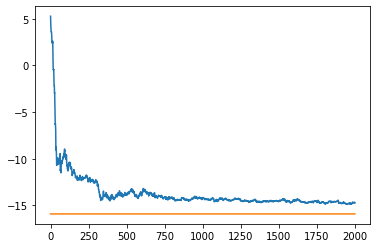

In [80]:
import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

In [55]:
import pickle

file_to_store = open("VQE_ByQubit"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_x_"+str(x)+"_y_"+str(y)+"_z_"+str(z)+".pickle", "wb")

pickle.dump(out, file_to_store)

In [56]:
import pickle

file_to_read = open("VQE_ByQubit"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_x_"+str(x)+"_y_"+str(y)+"_z_"+str(z)+".pickle", "rb")

loaded_object = pickle.load(file_to_read)

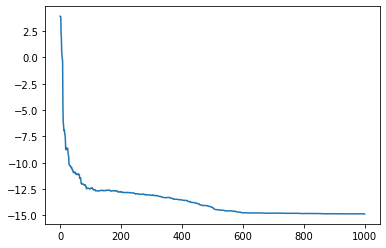

In [57]:
import matplotlib.pyplot as plt

El = [loaded_object[i]['E'] for i in range(len(loaded_object))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [58]:
a

0.03